In [1]:
!pip install catboost -q
!pip install GPUtil -q
!pip install pytorch-tabnet -q

     |████████████████████████████████| 76.6 MB 78 kB/s 
     |████████████████████████████████| 41 kB 671 kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

import gc
import os
from numpy import mean
from numpy import std

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage() 
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [4]:
df = pd.read_csv('./drive/MyDrive/ppdaiData.csv')

In [5]:
df.head()

,sex,occupation,education,marriage,household,income,outcome,income_tm,outcome_tm,tm_encode_3,...,cash_limit,repay_state,browse_data,loan_time,time,yu_e,yu_e_categery,yu_e_tm,yu_e_tm_categery,label
0,1,2,3,1,3,13.734079,13.255397,5.900126e+09,5.900935e+09,0.000000e+00,...,0.000000,0.0,0.0,5914855887,5.914856e+09,0.478681,1.0,-8.094010e+05,3.0,0
1,1,2,3,2,1,0.000000,0.000000,0.000000e+00,0.000000e+00,5.659685e+09,...,7.087560,0.0,151500.0,5914855887,2.551708e+08,0.000000,2.0,0.000000e+00,2.0,0
2,1,4,4,1,4,13.249264,9.834236,4.767557e+09,5.899778e+09,0.000000e+00,...,0.000000,0.0,38586.0,5914855887,5.914856e+09,3.415028,1.0,-1.132222e+09,3.0,0
3,1,4,4,3,2,12.128566,10.920132,5.042088e+09,5.902715e+09,5.912412e+09,...,7.808445,0.0,38764.0,5914855887,2.443522e+06,1.208435,1.0,-8.606264e+08,3.0,1
4,1,2,2,3,1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,19.971271,0.0,0.0,5914855887,5.914856e+09,0.000000,2.0,0.000000e+00,2.0,0


In [6]:
######### Pre-processing #########

In [7]:
#### Detect global outliers
ISF = IsolationForest(random_state=0)
df = df[ISF.fit_predict(df) == 1]

In [8]:
##### Detect local outliers
LOF = LocalOutlierFactor(n_neighbors=2)
df = df[LOF.fit_predict(df) == 1]

In [9]:
cat_cols= ['sex', 'occupation', 'education', 'marriage', 'household', 'yu_e_categery', 'yu_e_tm_categery']

In [10]:
#One-Hot-Endcoding
df = pd.get_dummies(df, columns = cat_cols)

In [11]:
df.shape

(38272, 53)

In [12]:
y = df.label
df.drop('label', axis = 1, inplace = True)

In [13]:
#Normalize
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [14]:
#Oversampling
sm = BorderlineSMOTE(random_state=42, n_jobs = -1)
X, y = sm.fit_resample(X, y)

In [15]:
gc.collect()

94

In [16]:
############# Base model ############

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify = y)
print('Size of train dataframe: ', X_train.shape)
print('Size of train dataframe: ', y_train.shape)
print('Size of test dataframe: ', X_test.shape)
print('Size of train dataframe: ', y_test.shape)

Size of train dataframe:  (54508, 52)
Size of train dataframe:  (54508,)
Size of test dataframe:  (13628, 52)
Size of train dataframe:  (13628,)


In [18]:
n_fold = 5

In [19]:
############### Random Forest model #############

In [20]:
rf = RandomForestClassifier(n_estimators=361,
                               random_state=42,
                           n_jobs = -1,
                           verbose = 0)

In [21]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_rf = []
auc_score_rf = []
f1_rf = []
meta_train_rf = []
meta_test_rf = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    rf.fit(train_X, train_y)
    ####meta
    meta_train_rf = np.append(meta_train_rf, rf.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_rf) == 0:
        meta_test_rf = rf.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_rf = np.add(meta_test_rf, rf.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    
    yhat = rf.predict(X_test)
    acc_score_rf.append(accuracy_score(yhat,y_test))
    auc_score_rf.append(roc_auc_score(yhat,y_test))
    f1_rf.append(f1_score(yhat,y_test))
    i += 1
meta_test_rf = np.divide(meta_test_rf, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###Random Forest Classifier###

Accuracy: 0.8937775168770179 +- 0.0011718500016247415
ROC-AUC: 0.8943086115026595 +- 0.0012060320723658604
F1-Score: 0.8956657306503969 +- 0.001222633084813102
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6814
           1       0.88      0.92      0.90      6814

    accuracy                           0.89     13628
   macro avg       0.89      0.89      0.89     13628
weighted avg       0.89      0.89      0.89     13628



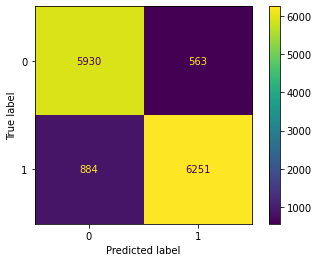

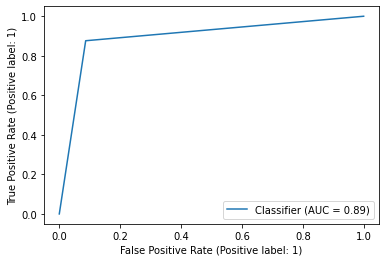

In [22]:
print("###Random Forest Classifier###\n")
print("Accuracy: " + str(mean(acc_score_rf)) + " +- "+ str(std(acc_score_rf)))
print("ROC-AUC: " + str(mean(auc_score_rf)) + " +- " + str(std(auc_score_rf)))
print("F1-Score: " + str(mean(f1_rf)) +" +- "+ str(std(f1_rf)))

yhat = rf.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [23]:
gc.collect()

2554

In [24]:
######### LightGBM model ###########

In [25]:
lgb = LGBMClassifier(
                boosting_type='gbdt',
                max_depth=10,
                learning_rate=0.05,
                n_estimators=450,
                objective = 'binary',
                random_state=42
)

In [26]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lgb = []
auc_score_lgb = []
f1_lgb = []
meta_train_lgb = []
meta_test_lgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_lgb = np.append(meta_train_lgb, lgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_lgb) == 0:
        meta_test_lgb = lgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_lgb = np.add(meta_test_lgb, lgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = lgb.predict(X_test)
    acc_score_lgb.append(accuracy_score(yhat,y_test))
    auc_score_lgb.append(roc_auc_score(yhat,y_test))
    f1_lgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_lgb = np.divide(meta_test_lgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###LightGBM Classifier###

Accuracy: 0.8967126504255944 +- 0.0032408313993369836
ROC-AUC: 0.8980780703949083 +- 0.0035086812286285528
F1-Score: 0.8936335551845562 +- 0.0030020713108638605
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6814
           1       0.92      0.87      0.90      6814

    accuracy                           0.90     13628
   macro avg       0.90      0.90      0.90     13628
weighted avg       0.90      0.90      0.90     13628



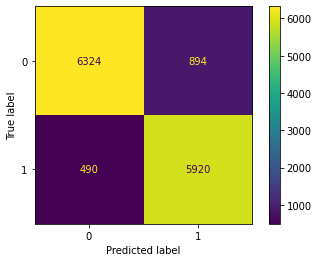

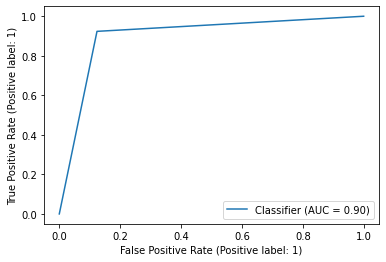

In [27]:
print("###LightGBM Classifier###\n")
print("Accuracy: " + str(mean(acc_score_lgb)) + " +- "+ str(std(acc_score_lgb)))
print("ROC-AUC: " + str(mean(auc_score_lgb)) + " +- " + str(std(auc_score_lgb)))
print("F1-Score: " + str(mean(f1_lgb)) +" +- "+ str(std(f1_lgb)))

yhat = lgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

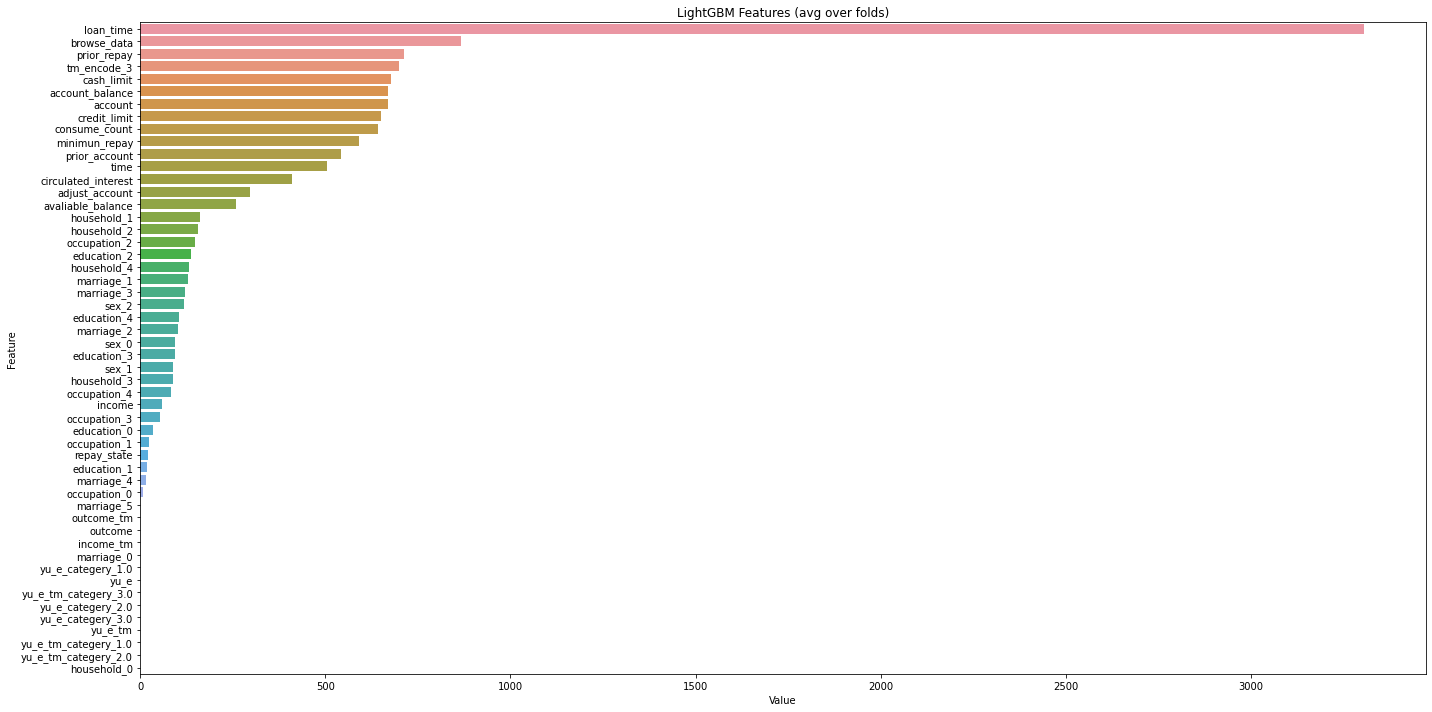

In [28]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [29]:
gc.collect()

18555

In [30]:
######## XGBoost model ##########

In [31]:
xgb  = XGBClassifier(
 learning_rate =0.05,
 n_estimators=410,
 max_depth=18,
 min_child_weight=4,
 subsample=0.5,
 objective= 'binary:logistic',
 random_state=42,
 tree_method='gpu_hist',
 gpu_id=0)

In [32]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_xgb = []
auc_score_xgb = []
f1_xgb = []
meta_train_xgb = []
meta_test_xgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_xgb = np.append(meta_train_xgb, xgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_xgb) == 0:
        meta_test_xgb = xgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_xgb = np.add(meta_test_xgb, xgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = xgb.predict(X_test)
    acc_score_xgb.append(accuracy_score(yhat,y_test))
    auc_score_xgb.append(roc_auc_score(yhat,y_test))
    f1_xgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_xgb = np.divide(meta_test_xgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###XGBoost Classifier###

Accuracy: 0.9081596712650427 +- 0.0017626692761515774
ROC-AUC: 0.9081987207182671 +- 0.0017701939471191038
F1-Score: 0.908595933080451 +- 0.001806515028222357
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6814
           1       0.90      0.91      0.91      6814

    accuracy                           0.91     13628
   macro avg       0.91      0.91      0.91     13628
weighted avg       0.91      0.91      0.91     13628



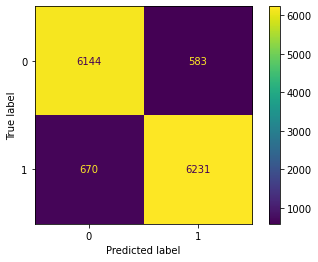

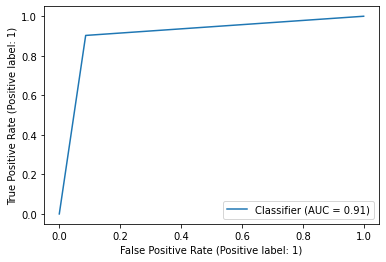

In [33]:
print("###XGBoost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_xgb)) + " +- "+ str(std(acc_score_xgb)))
print("ROC-AUC: " + str(mean(auc_score_xgb)) + " +- " + str(std(auc_score_xgb)))
print("F1-Score: " + str(mean(f1_xgb)) +" +- "+ str(std(f1_xgb)))

yhat = xgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

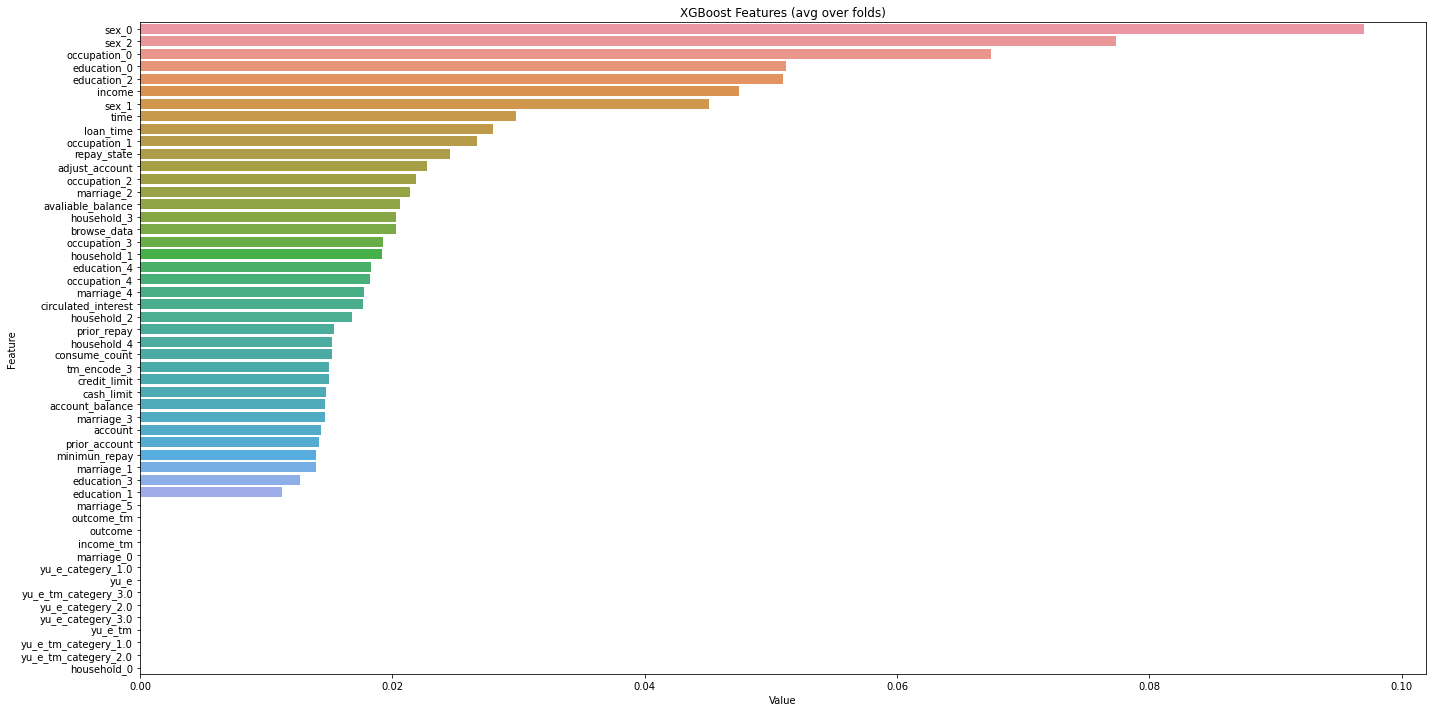

In [34]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [35]:
gc.collect()

18539

In [36]:
############ CatBoost ################

In [37]:
catb = CatBoostClassifier(iterations=450,
                           learning_rate=0.05,
                           depth=10,
                          task_type = "GPU")

In [38]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_catb = []
auc_score_catb = []
f1_catb = []
meta_train_catb = []
meta_test_catb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    catb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_catb = np.append(meta_train_catb, catb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_catb) == 0:
        meta_test_catb = catb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_catb = np.add(meta_test_catb, catb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = catb.predict(X_test)
    acc_score_catb.append(accuracy_score(yhat,y_test))
    auc_score_catb.append(roc_auc_score(yhat,y_test))
    f1_catb.append(f1_score(yhat,y_test))
    i += 1
meta_test_catb = np.divide(meta_test_catb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###Catboost Classifier###

Accuracy: 0.8984297035515116 +- 0.0012687452155298404
ROC-AUC: 0.8985122565938342 +- 0.0012829469364004805
F1-Score: 0.8977261591466691 +- 0.001225839754722564
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6814
           1       0.91      0.89      0.90      6814

    accuracy                           0.90     13628
   macro avg       0.90      0.90      0.90     13628
weighted avg       0.90      0.90      0.90     13628



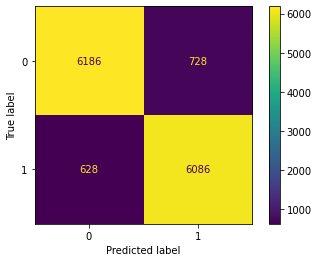

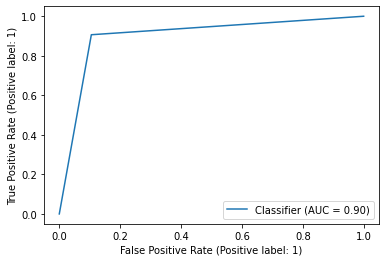

In [39]:
print("###Catboost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_catb)) + " +- "+ str(std(acc_score_catb)))
print("ROC-AUC: " + str(mean(auc_score_catb)) + " +- " + str(std(auc_score_catb)))
print("F1-Score: " + str(mean(f1_catb)) +" +- "+ str(std(f1_catb)))

yhat = catb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

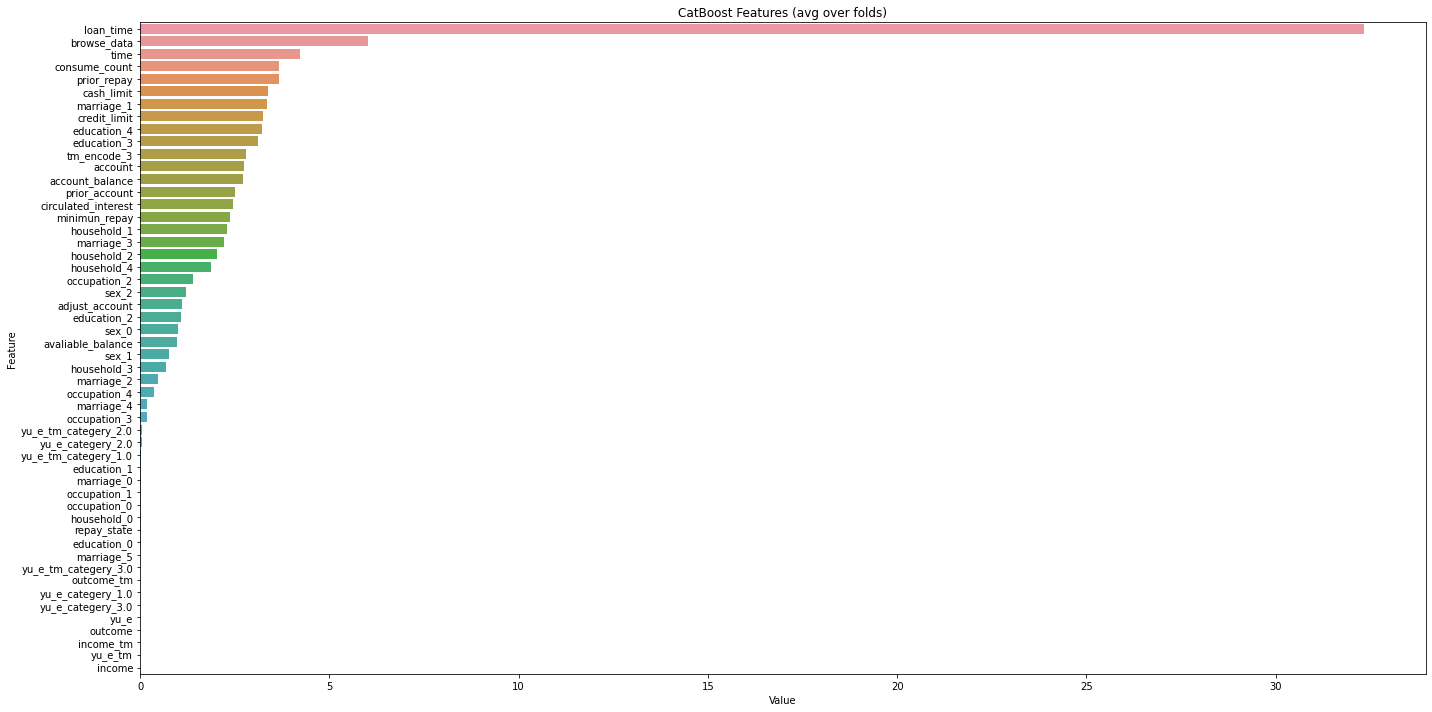

In [40]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(catb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()


In [41]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% |  1% |


In [42]:
######### GBDT #############

In [43]:
gbdt = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [44]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_gbdt = []
auc_score_gbdt = []
f1_gbdt = []
meta_train_gbdt = []
meta_test_gbdt = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    gbdt.fit(train_X, train_y)
    ####meta
    meta_train_gbdt = np.append(meta_train_gbdt, gbdt.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_gbdt) == 0:
        meta_test_gbdt = gbdt.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_gbdt = np.add(meta_test_gbdt, gbdt.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = gbdt.predict(X_test)
    acc_score_gbdt.append(accuracy_score(yhat,y_test))
    auc_score_gbdt.append(roc_auc_score(yhat,y_test))
    f1_gbdt.append(f1_score(yhat,y_test))
    i += 1
meta_test_gbdt = np.divide(meta_test_gbdt, n_fold)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3492           0.0299            2.56m
         2           1.3165           0.0279            2.59m
         3           1.2870           0.0273            2.61m
         4           1.2600           0.0238            2.60m
         5           1.2346           0.0203            2.61m
         6           1.2114           0.0209            2.62m
         7           1.1901           0.0179            2.61m
         8           1.1683           0.0178            2.61m
         9           1.1498           0.0148            2.60m
        10           1.1330           0.0151            2.61m
        20           0.9951           0.0091            2.55m
        30           0.9005           0.0066            2.48m
        40           0.8208           0.0056            2.41m
        50           0.7609           0.0043            2.35m
        60           0.6935           0.0023            

###GBDT Classifier###

Accuracy: 0.9290578221309069 +- 0.0010897609753881524
ROC-AUC: 0.9300096753044963 +- 0.0011129781293599216
F1-Score: 0.9273500085636996 +- 0.0011005138177652384
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      6814
           1       0.95      0.90      0.93      6814

    accuracy                           0.93     13628
   macro avg       0.93      0.93      0.93     13628
weighted avg       0.93      0.93      0.93     13628



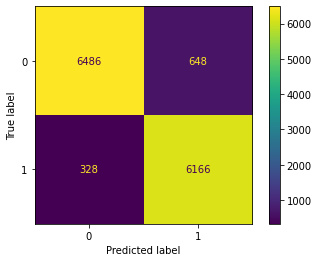

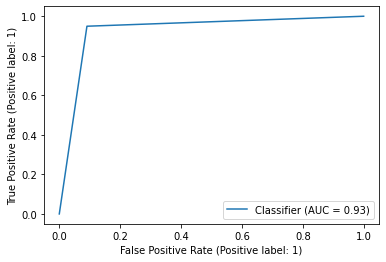

In [45]:
print("###GBDT Classifier###\n")
print("Accuracy: " + str(mean(acc_score_gbdt)) + " +- "+ str(std(acc_score_gbdt)))
print("ROC-AUC: " + str(mean(auc_score_gbdt)) + " +- " + str(std(auc_score_gbdt)))
print("F1-Score: " + str(mean(f1_gbdt)) +" +- "+ str(std(f1_gbdt)))

yhat = gbdt.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [46]:
gc.collect()

6244

In [47]:
########### 1D-CNN model #############

In [48]:
def EarlyStop(patience):
    return EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(
                     filepath=model_name, 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 )   

In [49]:
# Define 1D - CNN model
def create_model(input_shape):
    # Model Building
    model = Sequential()
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(input_shape,1)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_train.shape[1], 1)

# 1D-CNN model
cnn1d = create_model(input_shape = X_train_cnn.shape[1])   

In [50]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d = []
auc_score_cnn1d = []
f1_cnn1d = []
meta_train_cnn1d = []
meta_test_cnn1d = []
i = 1
for train_index, valid_index in kf.split(X_train_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train_cnn[train_index], X_train_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./cnn1d.h5')],
            verbose = 1)
    ####meta
    meta_train_cnn1d = np.append(meta_train_cnn1d, cnn1d.predict(val_X))
    
    if len(meta_test_cnn1d) == 0:
        meta_test_cnn1d = cnn1d.predict(X_test_cnn)
    else:
        meta_test_cnn1d = np.add(meta_test_cnn1d, cnn1d.predict(X_test_cnn))
    #####
    yhat = cnn1d.predict(X_test_cnn).round()
    acc_score_cnn1d.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d.append(roc_auc_score(yhat,y_test))
    f1_cnn1d.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d = np.divide(meta_test_cnn1d, n_fold)

KFold 1 of 5
Epoch 1/500
171/171 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.6451
Epoch 1: val_accuracy improved from -inf to 0.67345, saving model to ./cnn1d.h5
171/171 [==============================] - 12s 22ms/step - loss: 0.6257 - accuracy: 0.6451 - val_loss: 0.6034 - val_accuracy: 0.6735
Epoch 2/500
171/171 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.6747
Epoch 2: val_accuracy improved from 0.67345 to 0.68611, saving model to ./cnn1d.h5
171/171 [==============================] - 3s 18ms/step - loss: 0.5941 - accuracy: 0.6747 - val_loss: 0.5878 - val_accuracy: 0.6861
Epoch 3/500
168/171 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.6972
Epoch 3: val_accuracy improved from 0.68611 to 0.72134, saving model to ./cnn1d.h5
171/171 [==============================] - 3s 18ms/step - loss: 0.5666 - accuracy: 0.6975 - val_loss: 0.5489 - val_accuracy: 0.7213
Epoch 4/500
168/171 [============================>.] 

###1D-CNN Classifier###

Accuracy: 0.8884942764895802 +- 0.004927091811049382
ROC-AUC: 0.8893182240101769 +- 0.004556694485524708
F1-Score: 0.8908198813579185 +- 0.004280745698485116
426/426 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6814
           1       0.89      0.91      0.90      6814

    accuracy                           0.90     13628
   macro avg       0.90      0.90      0.90     13628
weighted avg       0.90      0.90      0.90     13628



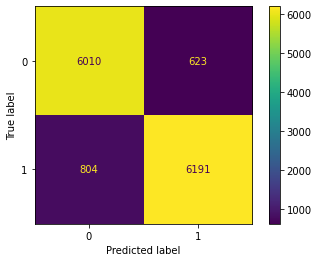

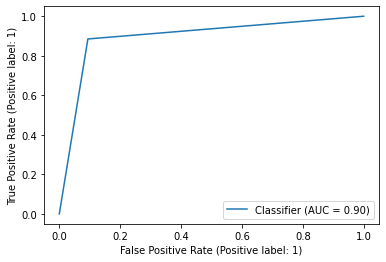

In [51]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(mean(acc_score_cnn1d)) + " +- "+ str(std(acc_score_cnn1d)))
print("ROC-AUC: " + str(mean(auc_score_cnn1d)) + " +- " + str(std(auc_score_cnn1d)))
print("F1-Score: " + str(mean(f1_cnn1d)) +" +- "+ str(std(f1_cnn1d)))

yhat = cnn1d.predict(X_test_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [52]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 38% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 49% |  1% |


In [53]:
########### TabNet #############

In [54]:
class roc_auc(Metric):
    def __init__(self):
        self._name = "roc_auc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        roc_auc = roc_auc_score(y_true, y_score[:, 1])
        return roc_auc

In [55]:
tabnet = TabNetClassifier(
                        n_d = 64,
                        n_a = 64,
                        n_steps = 3,
                        gamma = 1.3,
                        n_independent = 1,
                        n_shared = 2,
                        momentum = 0.02,
                        clip_value = None,
                        lambda_sparse = 1e-3,
                        optimizer_fn = torch.optim.Adam,
                        optimizer_params = dict(lr = 1e-3, weight_decay=1e-3),
                        scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                        scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                        mask_type = 'entmax',
                        verbose = 1
)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [56]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_tabnet = []
auc_score_tabnet = []
f1_tabnet = []
meta_train_tabnet = []
meta_test_tabnet = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    tabnet.fit(train_X, train_y.ravel(),
      eval_set=[(val_X, val_y.ravel())],
      eval_metric=[roc_auc, "accuracy"],
      max_epochs = 500,
      patience = 50,
      batch_size = 256)
    ####meta
    meta_train_tabnet = np.append(meta_train_tabnet, tabnet.predict_proba(val_X)[:,1].reshape(-1,1))
    
    if len(meta_test_tabnet) == 0:
        meta_test_tabnet = tabnet.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_tabnet = np.add(meta_test_tabnet, tabnet.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = tabnet.predict(X_test).round()
    acc_score_tabnet.append(accuracy_score(yhat,y_test))
    auc_score_tabnet.append(roc_auc_score(yhat,y_test))
    f1_tabnet.append(f1_score(yhat,y_test))
    i += 1
meta_test_tabnet = np.divide(meta_test_tabnet, n_fold)

KFold 1 of 5
epoch 0  | loss: 0.83298 | val_0_roc_auc: 0.61423 | val_0_accuracy: 0.58099 |  0:00:04s
epoch 1  | loss: 0.70675 | val_0_roc_auc: 0.64577 | val_0_accuracy: 0.60292 |  0:00:08s
epoch 2  | loss: 0.67371 | val_0_roc_auc: 0.66219 | val_0_accuracy: 0.60961 |  0:00:12s
epoch 3  | loss: 0.66003 | val_0_roc_auc: 0.6722  | val_0_accuracy: 0.62099 |  0:00:16s
epoch 4  | loss: 0.65121 | val_0_roc_auc: 0.67887 | val_0_accuracy: 0.62154 |  0:00:20s
epoch 5  | loss: 0.6473  | val_0_roc_auc: 0.7019  | val_0_accuracy: 0.64007 |  0:00:24s
epoch 6  | loss: 0.63241 | val_0_roc_auc: 0.71118 | val_0_accuracy: 0.6464  |  0:00:28s
epoch 7  | loss: 0.62226 | val_0_roc_auc: 0.717   | val_0_accuracy: 0.64896 |  0:00:31s
epoch 8  | loss: 0.61332 | val_0_roc_auc: 0.7292  | val_0_accuracy: 0.65832 |  0:00:35s
epoch 9  | loss: 0.6104  | val_0_roc_auc: 0.73348 | val_0_accuracy: 0.66364 |  0:00:39s
epoch 10 | loss: 0.61219 | val_0_roc_auc: 0.73898 | val_0_accuracy: 0.66465 |  0:00:43s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 2 of 5
epoch 0  | loss: 0.83751 | val_0_roc_auc: 0.60882 | val_0_accuracy: 0.57815 |  0:00:03s
epoch 1  | loss: 0.70663 | val_0_roc_auc: 0.66465 | val_0_accuracy: 0.61915 |  0:00:07s
epoch 2  | loss: 0.67325 | val_0_roc_auc: 0.6783  | val_0_accuracy: 0.62915 |  0:00:11s
epoch 3  | loss: 0.65882 | val_0_roc_auc: 0.6933  | val_0_accuracy: 0.64328 |  0:00:15s
epoch 4  | loss: 0.64776 | val_0_roc_auc: 0.69489 | val_0_accuracy: 0.64603 |  0:00:19s
epoch 5  | loss: 0.64802 | val_0_roc_auc: 0.70104 | val_0_accuracy: 0.65144 |  0:00:22s
epoch 6  | loss: 0.63507 | val_0_roc_auc: 0.71326 | val_0_accuracy: 0.66171 |  0:00:26s
epoch 7  | loss: 0.62558 | val_0_roc_auc: 0.71642 | val_0_accuracy: 0.66584 |  0:00:30s
epoch 8  | loss: 0.6183  | val_0_roc_auc: 0.72302 | val_0_accuracy: 0.66676 |  0:00:35s
epoch 9  | loss: 0.61241 | val_0_roc_auc: 0.7296  | val_0_accuracy: 0.67327 |  0:00:39s
epoch 10 | loss: 0.61686 | val_0_roc_auc: 0.73115 | val_0_accuracy: 0.66199 |  0:00:42s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 3 of 5
epoch 0  | loss: 0.85054 | val_0_roc_auc: 0.61335 | val_0_accuracy: 0.57476 |  0:00:03s
epoch 1  | loss: 0.70347 | val_0_roc_auc: 0.65393 | val_0_accuracy: 0.60338 |  0:00:07s
epoch 2  | loss: 0.673   | val_0_roc_auc: 0.67797 | val_0_accuracy: 0.62493 |  0:00:11s
epoch 3  | loss: 0.66093 | val_0_roc_auc: 0.68542 | val_0_accuracy: 0.63126 |  0:00:15s
epoch 4  | loss: 0.65136 | val_0_roc_auc: 0.68797 | val_0_accuracy: 0.62961 |  0:00:19s
epoch 5  | loss: 0.6501  | val_0_roc_auc: 0.70181 | val_0_accuracy: 0.64218 |  0:00:23s
epoch 6  | loss: 0.63617 | val_0_roc_auc: 0.71578 | val_0_accuracy: 0.65236 |  0:00:28s
epoch 7  | loss: 0.62592 | val_0_roc_auc: 0.72103 | val_0_accuracy: 0.64878 |  0:00:32s
epoch 8  | loss: 0.6214  | val_0_roc_auc: 0.72415 | val_0_accuracy: 0.6519  |  0:00:37s
epoch 9  | loss: 0.61934 | val_0_roc_auc: 0.72668 | val_0_accuracy: 0.65071 |  0:00:40s
epoch 10 | loss: 0.61991 | val_0_roc_auc: 0.71708 | val_0_accuracy: 0.64144 |  0:00:44s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 4 of 5
epoch 0  | loss: 0.84866 | val_0_roc_auc: 0.60556 | val_0_accuracy: 0.56793 |  0:00:03s
epoch 1  | loss: 0.70614 | val_0_roc_auc: 0.66029 | val_0_accuracy: 0.60985 |  0:00:07s
epoch 2  | loss: 0.67385 | val_0_roc_auc: 0.68183 | val_0_accuracy: 0.6338  |  0:00:12s
epoch 3  | loss: 0.65668 | val_0_roc_auc: 0.69321 | val_0_accuracy: 0.63967 |  0:00:17s
epoch 4  | loss: 0.65263 | val_0_roc_auc: 0.70008 | val_0_accuracy: 0.6459  |  0:00:20s
epoch 5  | loss: 0.64778 | val_0_roc_auc: 0.70959 | val_0_accuracy: 0.65233 |  0:00:24s
epoch 6  | loss: 0.63584 | val_0_roc_auc: 0.72074 | val_0_accuracy: 0.65966 |  0:00:28s
epoch 7  | loss: 0.62697 | val_0_roc_auc: 0.726   | val_0_accuracy: 0.66077 |  0:00:32s
epoch 8  | loss: 0.61814 | val_0_roc_auc: 0.73589 | val_0_accuracy: 0.66755 |  0:00:36s
epoch 9  | loss: 0.61399 | val_0_roc_auc: 0.73499 | val_0_accuracy: 0.65939 |  0:00:40s
epoch 10 | loss: 0.61502 | val_0_roc_auc: 0.74152 | val_0_accuracy: 0.67278 |  0:00:44s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 5 of 5
epoch 0  | loss: 0.84378 | val_0_roc_auc: 0.61998 | val_0_accuracy: 0.57435 |  0:00:03s
epoch 1  | loss: 0.70522 | val_0_roc_auc: 0.64385 | val_0_accuracy: 0.60031 |  0:00:07s
epoch 2  | loss: 0.67848 | val_0_roc_auc: 0.66424 | val_0_accuracy: 0.61371 |  0:00:11s
epoch 3  | loss: 0.66004 | val_0_roc_auc: 0.67824 | val_0_accuracy: 0.626   |  0:00:16s
epoch 4  | loss: 0.65115 | val_0_roc_auc: 0.68144 | val_0_accuracy: 0.62921 |  0:00:20s
epoch 5  | loss: 0.64912 | val_0_roc_auc: 0.69395 | val_0_accuracy: 0.64031 |  0:00:24s
epoch 6  | loss: 0.63841 | val_0_roc_auc: 0.69996 | val_0_accuracy: 0.64719 |  0:00:28s
epoch 7  | loss: 0.62732 | val_0_roc_auc: 0.71132 | val_0_accuracy: 0.64948 |  0:00:32s
epoch 8  | loss: 0.6191  | val_0_roc_auc: 0.71779 | val_0_accuracy: 0.65425 |  0:00:36s
epoch 9  | loss: 0.61608 | val_0_roc_auc: 0.72053 | val_0_accuracy: 0.65746 |  0:00:40s
epoch 10 | loss: 0.6151  | val_0_roc_auc: 0.73477 | val_0_accuracy: 0.66636 |  0:00:44s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.8794393894922219 +- 0.002788763046188768
ROC-AUC: 0.886017007017605 +- 0.002055546041882755
F1-Score: 0.8868178532674138 +- 0.0021942690150918197
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6814
           1       0.83      0.95      0.89      6814

    accuracy                           0.88     13628
   macro avg       0.89      0.88      0.88     13628
weighted avg       0.89      0.88      0.88     13628



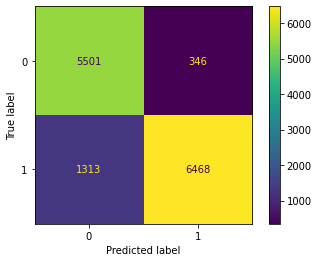

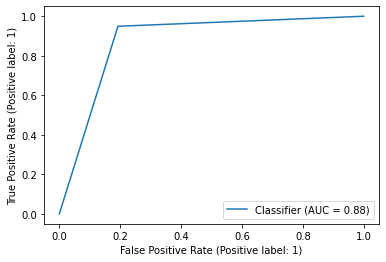

In [57]:
print("Accuracy: " + str(mean(acc_score_tabnet)) + " +- "+ str(std(acc_score_tabnet)))
print("ROC-AUC: " + str(mean(auc_score_tabnet)) + " +- " + str(std(auc_score_tabnet)))
print("F1-Score: " + str(mean(f1_tabnet)) +" +- "+ str(std(f1_tabnet)))


yhat = tabnet.predict(X_test).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

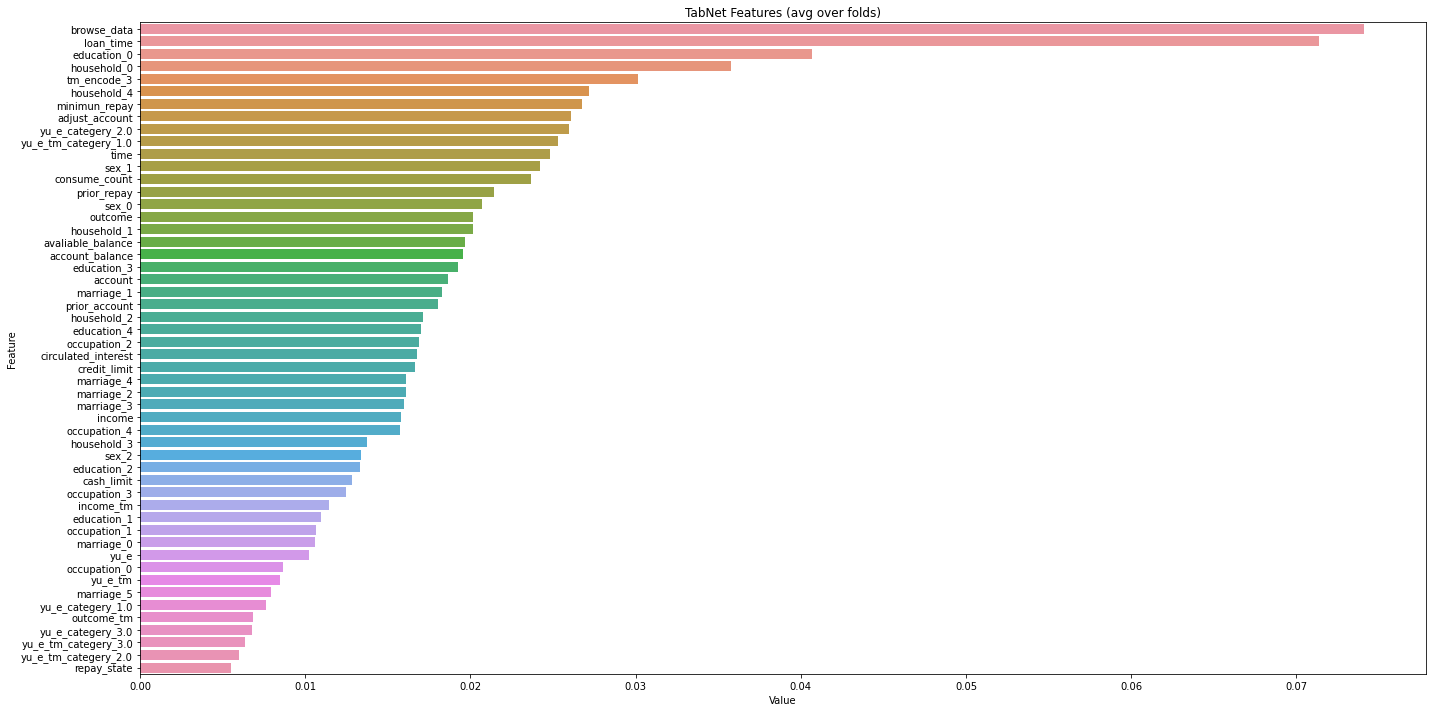

In [58]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(tabnet.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TabNet Features (avg over folds)')
plt.tight_layout()
plt.show()

In [59]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |


In [60]:
################# STACKING #####################

In [61]:
meta_train = pd.concat([ pd.DataFrame(X_train, columns=df.columns),
                          pd.DataFrame(meta_train_rf, columns=['RF']),
                          pd.DataFrame(meta_train_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_train_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_train_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_train_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_train_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_train_tabnet, columns=['TabNet'])], axis = 1)

In [62]:
meta_test = pd.concat([pd.DataFrame(X_test, columns=df.columns),
                          pd.DataFrame(meta_test_rf, columns=['RF']),
                          pd.DataFrame(meta_test_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_test_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_test_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_test_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_test_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_test_tabnet, columns=['TabNet'])], axis = 1)

In [63]:
meta_train.head()

,income,outcome,income_tm,outcome_tm,tm_encode_3,prior_account,prior_repay,credit_limit,account_balance,minimun_repay,...,yu_e_tm_categery_1.0,yu_e_tm_categery_2.0,yu_e_tm_categery_3.0,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,-0.061291,-0.061317,-0.061455,-0.061455,0.402906,-0.762929,0.883249,-0.543502,-2.367175,-2.742228,...,-0.050667,0.061241,-0.03431,0.603878,0.917741,0.856505,0.839259,0.855448,1.000000,0.960260
1,-0.061291,-0.061317,-0.061455,-0.061455,0.413680,1.056709,1.216170,0.581755,0.403987,0.006291,...,-0.050667,0.061241,-0.03431,0.204986,0.110483,0.028530,0.098305,0.019823,0.000108,0.018406
2,-0.061291,-0.061317,-0.061455,-0.061455,0.426274,-1.909469,-2.043342,-2.858685,-0.960897,-1.257651,...,-0.050667,0.061241,-0.03431,0.027701,0.019998,0.003516,0.003241,0.003482,0.000005,0.000736
3,-0.061291,-0.061317,-0.061455,-0.061455,0.418695,-1.668711,-1.793652,-2.858685,0.555719,1.012817,...,-0.050667,0.061241,-0.03431,0.930748,0.972240,0.968502,0.974947,0.991787,0.999193,0.977971
4,-0.061291,-0.061317,-0.061455,-0.061455,-1.471115,0.644818,0.576527,-0.332260,0.273205,0.264268,...,-0.050667,0.061241,-0.03431,0.941828,0.358622,0.865002,0.654118,0.519584,0.996882,0.955238


In [64]:
meta_test.head()

,income,outcome,income_tm,outcome_tm,tm_encode_3,prior_account,prior_repay,credit_limit,account_balance,minimun_repay,...,yu_e_tm_categery_1.0,yu_e_tm_categery_2.0,yu_e_tm_categery_3.0,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,-0.061291,-0.061317,-0.061455,-0.061455,0.423232,-1.909469,-2.043342,0.487781,0.188208,0.201017,...,-0.050667,0.061241,-0.03431,0.807202,0.887734,0.929765,0.907821,0.965342,0.717038,0.987120
1,-0.061291,-0.061317,-0.061455,-0.061455,0.425230,1.330673,1.316589,0.945383,0.937814,-7.625785,...,-0.050667,0.061241,-0.03431,0.358449,0.263027,0.231222,0.172579,0.289018,0.783686,0.939039
2,-0.061291,-0.061317,-0.061455,-0.061455,0.395126,0.503023,0.146218,-0.394081,0.411757,0.586502,...,-0.050667,0.061241,-0.03431,0.517452,0.907794,0.638312,0.792320,0.900848,0.906016,0.288273
3,-0.061291,-0.061317,-0.061455,-0.061455,0.409446,0.657780,0.753308,0.585895,-0.040167,-0.200769,...,-0.050667,0.061241,-0.03431,0.535180,0.387874,0.315794,0.387588,0.196961,0.009482,0.059200
4,-0.061291,-0.061317,-0.061455,-0.061455,0.402984,1.308491,-1.960451,0.930316,1.136488,2.037562,...,-0.050667,0.061241,-0.03431,0.779501,0.968981,0.964142,0.933774,0.988501,0.992531,0.991120


In [65]:
meta_train.to_pickle('./drive/MyDrive/meta_train.pkl')
meta_test.to_pickle('./drive/MyDrive/meta_test.pkl')

y_train.to_pickle('./drive/MyDrive/y_train.pkl')
y_test.to_pickle('./drive/MyDrive/y_test.pkl')

In [ ]:
########### Stacking level 1 ###############

In [66]:
stacking_lv1_xgb  = XGBClassifier(
 learning_rate =0.05,
 n_estimators=410,
 max_depth=18,
 min_child_weight=4,
 subsample=0.5,
 objective= 'binary:logistic',
 random_state=42,
 tree_method='gpu_hist',
 gpu_id=0)

In [67]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv1_xgb = []
auc_score_stacking_lv1_xgb = []
f1_stacking_lv1_xgb = []
meta_train_stacking_lv1_xgb = []
meta_test_stacking_lv1_xgb = []
i = 1
for train_index, valid_index in kf.split(meta_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train.iloc[train_index], meta_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv1_xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_stacking_lv1_xgb = np.append(meta_train_stacking_lv1_xgb, stacking_lv1_xgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv1_xgb) == 0:
        meta_test_stacking_lv1_xgb = stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv1_xgb = np.add(meta_test_stacking_lv1_xgb, stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv1_xgb.predict(meta_test)
    acc_score_stacking_lv1_xgb.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv1_xgb.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv1_xgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv1_xgb = np.divide(meta_test_stacking_lv1_xgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


Accuracy: 0.9575873202230701 +- 0.00400379543682638
ROC-AUC: 0.9577147814954559 +- 0.004063333915902979
F1-Score: 0.9573119670124562 +- 0.0038039625015773865
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6814
           1       0.97      0.95      0.96      6814

    accuracy                           0.96     13628
   macro avg       0.96      0.96      0.96     13628
weighted avg       0.96      0.96      0.96     13628



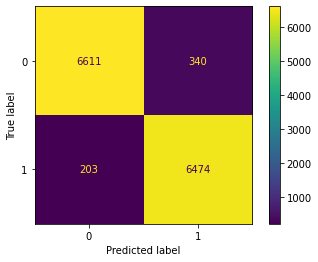

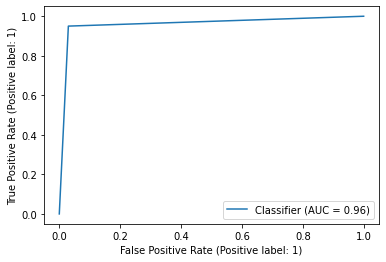

In [68]:
yhat = stacking_lv1_xgb.predict(meta_test)
print("Accuracy: " + str(mean(acc_score_stacking_lv1_xgb)) + " +- "+ str(std(acc_score_stacking_lv1_xgb)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv1_xgb)) + " +- " + str(std(auc_score_stacking_lv1_xgb)))
print("F1-Score: " + str(mean(f1_stacking_lv1_xgb)) +" +- "+ str(std(f1_stacking_lv1_xgb)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [69]:
stacking_lv1_gbdt  = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [70]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv1_gbdt = []
auc_score_stacking_lv1_gbdt = []
f1_stacking_lv1_gbdt = []
meta_train_stacking_lv1_gbdt = []
meta_test_stacking_lv1_gbdt = []
i = 1
for train_index, valid_index in kf.split(meta_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train.iloc[train_index], meta_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv1_gbdt.fit(train_X, train_y)
    ####meta
    meta_train_stacking_lv1_gbdt = np.append(meta_train_stacking_lv1_gbdt, stacking_lv1_gbdt.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv1_gbdt) == 0:
        meta_test_stacking_lv1_gbdt = stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv1_gbdt = np.add(meta_test_stacking_lv1_gbdt, stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv1_gbdt.predict(meta_test)
    acc_score_stacking_lv1_gbdt.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv1_gbdt.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv1_gbdt.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv1_gbdt = np.divide(meta_test_stacking_lv1_gbdt, n_fold)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2753           0.1057            3.51m
         2           1.1797           0.0938            3.39m
         3           1.0938           0.0833            3.48m
         4           1.0167           0.0748            3.51m
         5           0.9463           0.0674            3.53m
         6           0.8832           0.0614            3.53m
         7           0.8246           0.0557            3.55m
         8           0.7730           0.0507            3.54m
         9           0.7239           0.0460            3.55m
        10           0.6796           0.0425            3.55m
        20           0.3830           0.0190            3.71m
        30           0.2349           0.0093            3.57m
        40           0.1626           0.0049            3.98m
        50           0.1188           0.0023            3.79m
        60           0.0933           0.0012            

Accuracy: 0.9569709421778689 +- 0.004493151674347777
ROC-AUC: 0.957097032210604 +- 0.004550369236205505
F1-Score: 0.9566915495642228 +- 0.004299551526657553
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6814
           1       0.97      0.95      0.96      6814

    accuracy                           0.96     13628
   macro avg       0.96      0.96      0.96     13628
weighted avg       0.96      0.96      0.96     13628



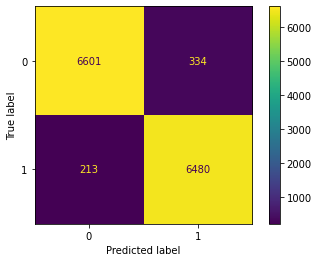

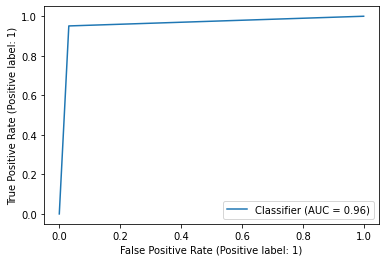

In [71]:
yhat = stacking_lv1_gbdt.predict(meta_test)
print("Accuracy: " + str(mean(acc_score_stacking_lv1_gbdt)) + " +- "+ str(std(acc_score_stacking_lv1_gbdt)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv1_gbdt)) + " +- " + str(std(auc_score_stacking_lv1_gbdt)))
print("F1-Score: " + str(mean(f1_stacking_lv1_gbdt)) +" +- "+ str(std(f1_stacking_lv1_gbdt)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [ ]:
######### Stacking level 2 ##########

In [72]:
meta_train_lv1 = pd.concat([#meta_train,
                          pd.DataFrame(stacking_lv1_xgb.predict_proba(meta_train)[:,1].reshape(-1,1), columns=['lv1_xgb_train']),
                       pd.DataFrame(stacking_lv1_gbdt.predict_proba(meta_train)[:,1].reshape(-1,1), columns=['lv1_gbdt_train']),
                        ], axis = 1)

In [73]:
meta_test_lv1 = pd.concat([#meta_test,
                           pd.DataFrame(stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1), columns=['lv1_xgb_test']),
                       pd.DataFrame(stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1), columns=['lv1_gbdt_test']),
                        ], axis = 1)

In [74]:
stacking_lv2_lr = LogisticRegression(random_state=0)

In [75]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv2_lr = []
auc_score_stacking_lv2_lr = []
f1_stacking_lv2_lr = []
meta_train_stacking_lv2_lr = []
meta_test_stacking_lv2_lr = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv1, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv1.iloc[train_index], meta_train_lv1.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv2_lr.fit(train_X, train_y)
    ####meta
    meta_train_stacking_lv2_lr = np.append(meta_train_stacking_lv2_lr, stacking_lv2_lr.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv2_lr) == 0:
        meta_test_stacking_lv2_lr = stacking_lv2_lr.predict_proba(meta_test_lv1)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv2_lr = np.add(meta_test_stacking_lv2_lr, stacking_lv2_lr.predict_proba(meta_test_lv1)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv2_lr.predict(meta_test_lv1)
    acc_score_stacking_lv2_lr.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv2_lr.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv2_lr.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv2_lr = np.divide(meta_test_stacking_lv2_lr, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


Accuracy: 0.9598914000587027 +- 0.00019469473380426852
ROC-AUC: 0.9599863193706994 +- 0.00021318128555214246
F1-Score: 0.9596027880598189 +- 0.0001696929794086649
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6814
           1       0.97      0.95      0.96      6814

    accuracy                           0.96     13628
   macro avg       0.96      0.96      0.96     13628
weighted avg       0.96      0.96      0.96     13628



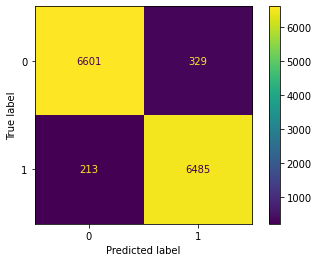

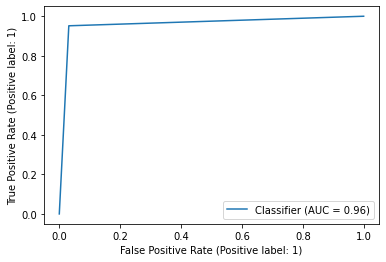

In [76]:
yhat = stacking_lv2_lr.predict(meta_test_lv1)
print("Accuracy: " + str(mean(acc_score_stacking_lv2_lr)) + " +- "+ str(std(acc_score_stacking_lv2_lr)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv2_lr)) + " +- " + str(std(auc_score_stacking_lv2_lr)))
print("F1-Score: " + str(mean(f1_stacking_lv2_lr)) +" +- "+ str(std(f1_stacking_lv2_lr)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()